In [1]:
!pip install -q tensorflow==2.8.0

You should consider upgrading via the '/home/ec2-user/anaconda3/envs/tensorflow2_p38/bin/python -m pip install --upgrade pip' command.


In [2]:
import boto3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
from sagemaker import get_execution_role

role = get_execution_role()
bucket='coolbuk'
data_key = 'Car_Data.json'
data_location = 's3://{}/{}'.format(bucket, data_key)

df = pd.read_json(data_location, orient='records')

## Steps:
1. Explore Categorical and Numerical Features
2. Create Year, Car Make, and Car Model Columns
3. Feature Engineering (Missing values, Deduplication, Categorical Encoding)
4. Standardization, Normalization
5. Setup X and Y
6. Split into Training and Testing set
7. Build ANN Regression Model
8. Use Keras Tuner for Hyperparameter Tuning
9. Deploy Model to API Gateway

In [4]:
df = df.drop('index', axis = 1)
df

,Car_Name,Price,Miles,Is_New
0,2019 Chevrolet Equinox 1.5T LT AWD,"$18,150","85,898 mi",False
1,2019 Jeep Grand Cherokee Summit 4WD,"$39,999","17,031 mi",False
2,2021 Kia Soul GT-Line FWD,"$19,999","8,388 mi",False
3,2019 Kia Sedona LX FWD,"$25,911","30,918 mi",False
4,2015 GMC Acadia Denali AWD,"$13,995","128,037 mi",False
...,...,...,...,...
745,2020 Ford Edge Titanium FWD,"$25,779","62,519 mi",False
746,2015 Jeep Grand Cherokee Limited 4WD,"$17,295","109,259 mi",False
747,2020 Chevrolet Equinox 1.5T Premier AWD,"$23,995","34,510 mi",False
748,2020 Lincoln Navigator Reserve 4WD,"$66,995","16,210 mi",False


In [5]:
# Simple Text Preprocessing
df['Price'] = df['Price'].str.replace('$', '').str.replace(',', '')
df['Miles'] = df['Miles'].str.replace('mi', '').str.replace(',', '')
df['Miles'] = df['Miles'].astype(int)

/tmp/ipykernel_28852/3399988603.py:2: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  df['Price'] = df['Price'].str.replace('$', '').str.replace(',', '')


In [6]:
df.Car_Name.unique()

array(['2019 Chevrolet Equinox 1.5T LT AWD',
       '2019 Jeep Grand Cherokee Summit 4WD', '2021 Kia Soul GT-Line FWD',
       '2019 Kia Sedona LX FWD', '2015 GMC Acadia Denali AWD',
       '2021 Chevrolet Blazer RS AWD', '2014 Ford Explorer XLT',
       '2014 Nissan Juke SL AWD', '2020 GMC Terrain Denali AWD',
       '2018 Nissan Rogue SL AWD', '2017 Nissan Altima 2.5 SR',
       '2019 Buick Encore Essence FWD', '2016 Toyota 4Runner Limited 4WD',
       '2019 Audi e-tron Prestige quattro AWD',
       '2021 Mazda CX-5 Touring FWD', '2011 Ford Taurus SEL',
       '2019 Hyundai Tucson Sport AWD', '2020 Chevrolet Blazer RS FWD',
       '2015 Chevrolet Equinox 1LT FWD',
       '2016 Jeep Grand Cherokee SRT 4WD', '2016 Dodge Durango R/T AWD',
       '2016 Toyota Highlander XLE', '2017 Chevrolet Equinox LT FWD',
       '2016 Toyota RAV4 LE', '2015 Chevrolet Equinox 1LT AWD',
       '2020 Ford Edge Titanium FWD',
       '2015 Jeep Grand Cherokee Limited 4WD',
       '2020 Chevrolet Equinox 1.

## Explore Categorical Features

In [7]:
df[['Year', 'Model', 'Model_Part_2', 'Model_Part_3', 'Model_Part_4', 'Model_Part_5']] = df['Car_Name'].str.split(expand=True)

In [8]:
df

,Car_Name,Price,Miles,Is_New,Year,Model,Model_Part_2,Model_Part_3,Model_Part_4,Model_Part_5
0,2019 Chevrolet Equinox 1.5T LT AWD,18150,85898,False,2019,Chevrolet,Equinox,1.5T,LT,AWD
1,2019 Jeep Grand Cherokee Summit 4WD,39999,17031,False,2019,Jeep,Grand,Cherokee,Summit,4WD
2,2021 Kia Soul GT-Line FWD,19999,8388,False,2021,Kia,Soul,GT-Line,FWD,None
3,2019 Kia Sedona LX FWD,25911,30918,False,2019,Kia,Sedona,LX,FWD,None
4,2015 GMC Acadia Denali AWD,13995,128037,False,2015,GMC,Acadia,Denali,AWD,None
...,...,...,...,...,...,...,...,...,...,...
745,2020 Ford Edge Titanium FWD,25779,62519,False,2020,Ford,Edge,Titanium,FWD,None
746,2015 Jeep Grand Cherokee Limited 4WD,17295,109259,False,2015,Jeep,Grand,Cherokee,Limited,4WD
747,2020 Chevrolet Equinox 1.5T Premier AWD,23995,34510,False,2020,Chevrolet,Equinox,1.5T,Premier,AWD
748,2020 Lincoln Navigator Reserve 4WD,66995,16210,False,2020,Lincoln,Navigator,Reserve,4WD,None


In [9]:
df.rename(columns={'Model': 'Make'}, inplace=True)
df['Model_Part_5'] = np.where(df['Model_Part_5'] == None, "", "")
df['Model'] = df['Model_Part_2'] + ' '+ ' ' + df['Model_Part_3'] + ' ' + df['Model_Part_4'] + ' ' + df['Model_Part_5']
df.drop(['Model_Part_2', 'Model_Part_3', 'Model_Part_4', 'Model_Part_5'], axis = 1, inplace=True)
df.head()

,Car_Name,Price,Miles,Is_New,Year,Make,Model
0,2019 Chevrolet Equinox 1.5T LT AWD,18150,85898,False,2019,Chevrolet,Equinox 1.5T LT
1,2019 Jeep Grand Cherokee Summit 4WD,39999,17031,False,2019,Jeep,Grand Cherokee Summit
2,2021 Kia Soul GT-Line FWD,19999,8388,False,2021,Kia,Soul GT-Line FWD
3,2019 Kia Sedona LX FWD,25911,30918,False,2019,Kia,Sedona LX FWD
4,2015 GMC Acadia Denali AWD,13995,128037,False,2015,GMC,Acadia Denali AWD


/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Make', ylabel='count'>

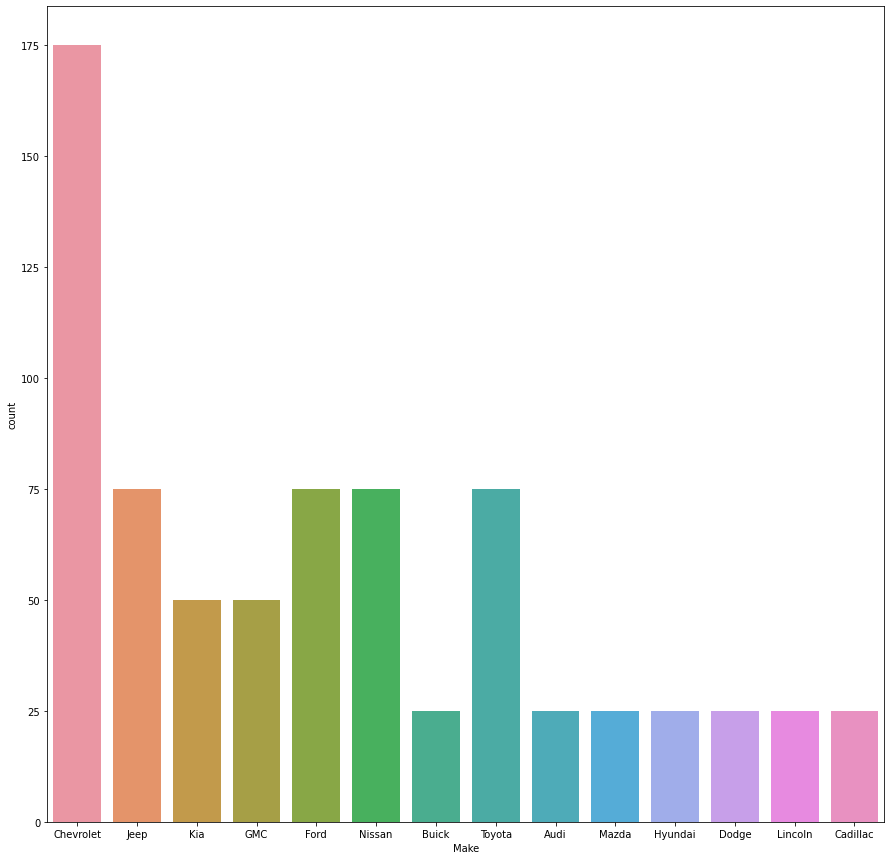

In [10]:
plt.figure(figsize=(15, 15))
sns.countplot(df['Make'])

The majority of cars are Chevrolets following Jeeps, Fords, Nissans, and Toyotas.

In [11]:
pd.get_dummies(df['Make'])

,Audi,Buick,Cadillac,Chevrolet,Dodge,Ford,GMC,Hyundai,Jeep,Kia,Lincoln,Mazda,Nissan,Toyota
0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,0,0,0,0,0,1,0,0,0,0,0,0,0,0
746,0,0,0,0,0,0,0,0,1,0,0,0,0,0
747,0,0,0,1,0,0,0,0,0,0,0,0,0,0
748,0,0,0,0,0,0,0,0,0,0,1,0,0,0


## Exploring Numerical Variables

/home/ec2-user/anaconda3/envs/tensorflow2_p38/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


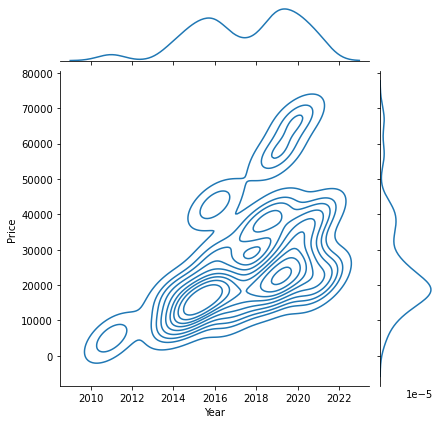

In [12]:
df['Year'] = df['Year'].astype(int)
df['Price'] = df['Price'].astype(int)
sns.jointplot(df['Year'], df['Price'], kind= 'kde')

As shown above, the majority of Cars range between 2016-2022 with a Price range between 10000 to 40000

(array([ 50., 150., 250., 100.,  50.,  75.,  25.,   0.,  25.,  25.]),
 array([ 4950. , 11154.5, 17359. , 23563.5, 29768. , 35972.5, 42177. ,
        48381.5, 54586. , 60790.5, 66995. ]),
 <BarContainer object of 10 artists>)

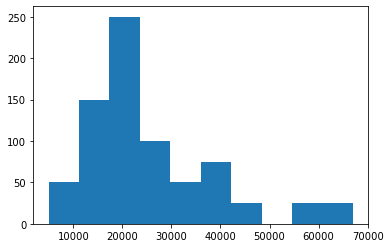

In [13]:
plt.hist(df['Price'])

The majority of prices range between 10000 to 25000

<AxesSubplot:xlabel='Make', ylabel='Price'>

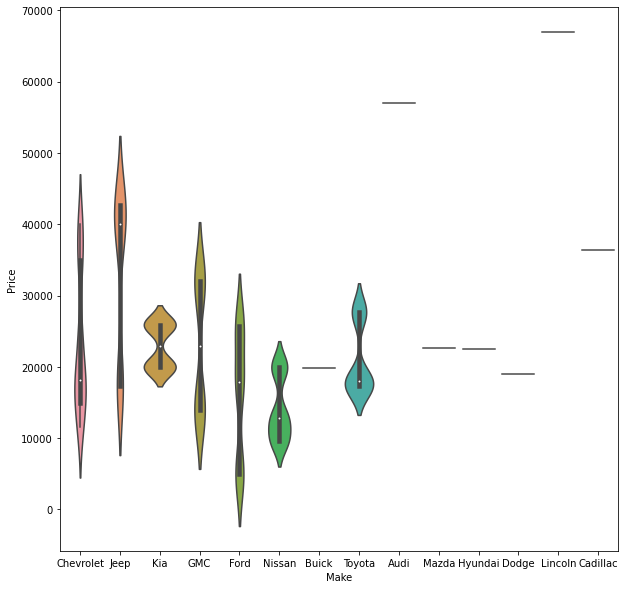

In [14]:
plt.figure(figsize=(10, 10))
sns.violinplot(x='Make', y='Price', data=df)

The Chevrolet and Jeep Car Makes had the widest price range.  There were also a wide variety of Kias and Toyotas within a similar price range.

## Feature Engineering

In [15]:
overall_df = pd.concat([df, pd.get_dummies(df['Make'])], axis = 1)
overall_df.drop('Car_Name', axis = 1, inplace=True)
overall_df.drop('Make', axis = 1, inplace=True)
overall_df.drop('Is_New', axis = 1, inplace=True)
overall_df.drop('Model', axis = 1, inplace=True)
overall_df

,Price,Miles,Year,Audi,Buick,Cadillac,Chevrolet,Dodge,Ford,GMC,Hyundai,Jeep,Kia,Lincoln,Mazda,Nissan,Toyota
0,18150,85898,2019,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,39999,17031,2019,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,19999,8388,2021,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,25911,30918,2019,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,13995,128037,2015,0,0,0,0,0,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
745,25779,62519,2020,0,0,0,0,0,1,0,0,0,0,0,0,0,0
746,17295,109259,2015,0,0,0,0,0,0,0,0,1,0,0,0,0,0
747,23995,34510,2020,0,0,0,1,0,0,0,0,0,0,0,0,0,0
748,66995,16210,2020,0,0,0,0,0,0,0,0,0,0,1,0,0,0


### Taking Care of Missing Values

In [16]:
overall_df.isnull().sum()

Price        0
Miles        0
Year         0
Audi         0
Buick        0
Cadillac     0
Chevrolet    0
Dodge        0
Ford         0
GMC          0
Hyundai      0
Jeep         0
Kia          0
Lincoln      0
Mazda        0
Nissan       0
Toyota       0
dtype: int64

## Deduplication

In [17]:
overall_df = overall_df.drop_duplicates(subset=overall_df.columns.to_list())
overall_df

,Price,Miles,Year,Audi,Buick,Cadillac,Chevrolet,Dodge,Ford,GMC,Hyundai,Jeep,Kia,Lincoln,Mazda,Nissan,Toyota
0,18150,85898,2019,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,39999,17031,2019,0,0,0,0,0,0,0,0,1,0,0,0,0,0
2,19999,8388,2021,0,0,0,0,0,0,0,0,0,1,0,0,0,0
3,25911,30918,2019,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,13995,128037,2015,0,0,0,0,0,0,1,0,0,0,0,0,0,0
5,39998,20212,2021,0,0,0,1,0,0,0,0,0,0,0,0,0,0
6,17900,55063,2014,0,0,0,0,0,1,0,0,0,0,0,0,0,0
7,9667,86807,2014,0,0,0,0,0,0,0,0,0,0,0,0,1,0
8,31990,15926,2020,0,0,0,0,0,0,1,0,0,0,0,0,0,0
9,19950,42768,2018,0,0,0,0,0,0,0,0,0,0,0,0,1,0


<AxesSubplot:>

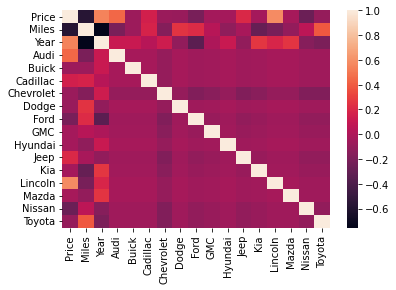

In [18]:
sns.heatmap(overall_df.corr())

### Feature Selection

In [19]:
overall_df.corr()

,Price,Miles,Year,Audi,Buick,Cadillac,Chevrolet,Dodge,Ford,GMC,Hyundai,Jeep,Kia,Lincoln,Mazda,Nissan,Toyota
Price,1.000000,-0.570003,0.547212,0.439225,-0.071756,0.155608,-0.080578,-0.083419,-0.218508,-0.040930,-0.035226,0.204378,-0.041672,0.576763,-0.033988,-0.269820,-0.100529
Miles,-0.570003,1.000000,-0.755083,-0.212388,-0.070934,0.173842,-0.165639,0.251318,0.212442,0.038071,-0.123569,-0.025328,-0.293408,-0.219016,-0.105026,0.056860,0.384818
Year,0.547212,-0.755083,1.000000,0.109537,0.109537,0.034853,0.135239,-0.114516,-0.339624,-0.003583,0.109537,-0.116187,0.265139,0.184221,0.258905,-0.160875,-0.205562
Audi,0.439225,-0.212388,0.109537,1.000000,-0.034483,-0.034483,-0.102444,-0.034483,-0.061898,-0.049629,-0.034483,-0.061898,-0.049629,-0.034483,-0.034483,-0.061898,-0.061898
Buick,-0.071756,-0.070934,0.109537,-0.034483,1.000000,-0.034483,-0.102444,-0.034483,-0.061898,-0.049629,-0.034483,-0.061898,-0.049629,-0.034483,-0.034483,-0.061898,-0.061898
Cadillac,0.155608,0.173842,0.034853,-0.034483,-0.034483,1.000000,-0.102444,-0.034483,-0.061898,-0.049629,-0.034483,-0.061898,-0.049629,-0.034483,-0.034483,-0.061898,-0.061898
Chevrolet,-0.080578,-0.165639,0.135239,-0.102444,-0.102444,-0.102444,1.000000,-0.102444,-0.183892,-0.147442,-0.102444,-0.183892,-0.147442,-0.102444,-0.102444,-0.183892,-0.183892
Dodge,-0.083419,0.251318,-0.114516,-0.034483,-0.034483,-0.034483,-0.102444,1.000000,-0.061898,-0.049629,-0.034483,-0.061898,-0.049629,-0.034483,-0.034483,-0.061898,-0.061898
Ford,-0.218508,0.212442,-0.339624,-0.061898,-0.061898,-0.061898,-0.183892,-0.061898,1.000000,-0.089087,-0.061898,-0.111111,-0.089087,-0.061898,-0.061898,-0.111111,-0.111111
GMC,-0.040930,0.038071,-0.003583,-0.049629,-0.049629,-0.049629,-0.147442,-0.049629,-0.089087,1.000000,-0.049629,-0.089087,-0.071429,-0.049629,-0.049629,-0.089087,-0.089087


In [20]:
corr_lst = []
for val in overall_df.corr():
    for val_2 in overall_df.corr():
        if val != val_2:
            if overall_df.corr().loc[val, val_2] > 0.7:
                corr_lst.append((val, val_2))

In [21]:
from sklearn.model_selection import train_test_split
X = overall_df.drop('Price', axis = 1)
y = overall_df['Price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## Building the Neural Network

In [22]:
#!pip install keras_tuner

In [25]:
from tensorflow import keras
import tensorflow.keras.layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

In [26]:
model = Sequential()
model.add(Dense(4, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(4, activation='relu'))
model.add(Dense(1))

In [27]:
# mean squared error regression prlem
# optimizer
model.compile(optimizer = 'rmsprop', loss = 'mse')

In [28]:

# epoch => 1 pass over entire dataset

#model.fit(X_train, y_train, epochs=50)
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24 entries, 26 to 11
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype
---  ------     --------------  -----
 0   Miles      24 non-null     int64
 1   Year       24 non-null     int64
 2   Audi       24 non-null     uint8
 3   Buick      24 non-null     uint8
 4   Cadillac   24 non-null     uint8
 5   Chevrolet  24 non-null     uint8
 6   Dodge      24 non-null     uint8
 7   Ford       24 non-null     uint8
 8   GMC        24 non-null     uint8
 9   Hyundai    24 non-null     uint8
 10  Jeep       24 non-null     uint8
 11  Kia        24 non-null     uint8
 12  Lincoln    24 non-null     uint8
 13  Mazda      24 non-null     uint8
 14  Nissan     24 non-null     uint8
 15  Toyota     24 non-null     uint8
dtypes: int64(2), uint8(14)
memory usage: 912.0 bytes


In [29]:
model.fit(X_train, y_train, epochs=250)

Epoch 1/250
1/1 [==============================] - 1s 567ms/step - loss: 698029824.0000
Epoch 2/250
1/1 [==============================] - 0s 6ms/step - loss: 688826496.0000
Epoch 3/250
1/1 [==============================] - 0s 6ms/step - loss: 682512128.0000
Epoch 4/250
1/1 [==============================] - 0s 4ms/step - loss: 677414144.0000
Epoch 5/250
1/1 [==============================] - 0s 5ms/step - loss: 673230016.0000
Epoch 6/250
1/1 [==============================] - 0s 5ms/step - loss: 669562944.0000
Epoch 7/250
1/1 [==============================] - 0s 4ms/step - loss: 666310976.0000
Epoch 8/250
1/1 [==============================] - 0s 4ms/step - loss: 663296704.0000
Epoch 9/250
1/1 [==============================] - 0s 5ms/step - loss: 660456512.0000
Epoch 10/250
1/1 [==============================] - 0s 4ms/step - loss: 657785536.0000
Epoch 11/250
1/1 [==============================] - 0s 5ms/step - loss: 655187328.0000
Epoch 12/250
1/1 [==============================] 

<AxesSubplot:>

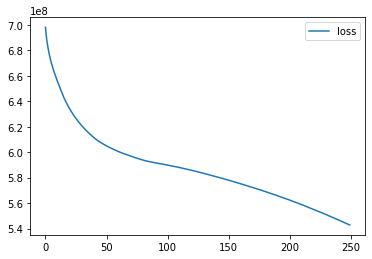

In [30]:
loss_df = pd.DataFrame(model.history.history)
loss_df.plot()

## Hyperparameter Tuning

In [31]:
import keras_tuner
from tensorflow.keras import layers
def build_model(hp):
    model = Sequential()
    
    # Hyperparameter Integer => function that returns the value of the hyperparameter with 
    # name=> num_layers
    # min_value => 2
    # max_value => 20
    for i in range(hp.Int('num_layers', 2, 20)):
        # Define the Dense Input Layers
        model.add(
            layers.Dense(
                # Define hyperparameters with min value of 32, max value of 512 with step size of 32
                units= hp.Int("units", min_value = 32, max_value=512, step=32),
                activation='relu',
            )

        )
    # Define the output layer
    model.add(layers.Dense(1, activation='relu'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            # choice of one value among a predefined set of learning rates
            hp.Choice('learning_rate', [1e-2, 1e-3, 1e-4, 1e-5]),
            hp.Choice('epsilon', [1e-5, 1e-6, 1e-7, 1e-8])),
        loss='mean_absolute_error',
        metrics=['mean_absolute_error']
        )
    
    
    return model

In [32]:
# Set the Random Search with the right parameters
from keras_tuner import RandomSearch
def hyperparameter_tune():
    
    # objective => we will minimize the sumof all objectives to minimize subtracting the sum of all objectives to maximize
    tuner = RandomSearch(
        build_model, 
        objective='val_mean_absolute_error',
        max_trials=5,
        executions_per_trial=3)
    print(tuner.search_space_summary())
    tuner.search(X_train, y_train, epochs=5, validation_data=(X_test, y_test))
    model = tuner.get_best_models(num_models=1)[0]
    model.fit(X_train, y_train, epochs=1000, validation_split=0.1)
    df = pd.DataFrame(model.history.history)
    return df

In [33]:
def model_evaluate(df):
    df.plot()

The Mean Absolute Error and Validation Mean Absolute Error both do well and are fairly consistent.

INFO:tensorflow:Reloading Oracle from existing project ./untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from ./untitled_project/tuner0.json
Search space summary
Default search space size: 4
num_layers (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 20, 'step': 1, 'sampling': None}
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001, 1e-05], 'ordered': True}
epsilon (Choice)
{'default': 1e-05, 'conditions': [], 'values': [1e-05, 1e-06, 1e-07, 1e-08], 'ordered': True}
None
INFO:tensorflow:Oracle triggered exit
Epoch 1/1000
1/1 [==============================] - 1s 1s/step - loss: 20637.9590 - mean_absolute_error: 20637.9590 - val_loss: 157171.1562 - val_mean_absolute_error: 157171.1562
Epoch 2/1000
1/1 [==============================] - 0s 49ms/step - loss: 248262.6719 - mean_absolute_error: 248262.6719

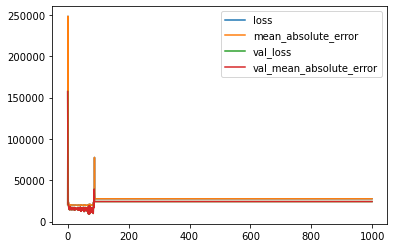

In [34]:
df = hyperparameter_tune()
model_evaluate(df)

In [35]:
model.save('keras_model/model.h5')
model_json = model.to_json()
with open("keras_model/model.json", "w") as json_file:
    json_file.write(model_json)

In [36]:
import h5py
from sagemaker.tensorflow.serving import Model

In [37]:
import os
with open(os.path.join('keras_model/', 'model.json'), 'r') as fp:
    loaded_model_json = fp.read()

In [38]:
from tensorflow import keras
loaded_model = keras.models.model_from_json(loaded_model_json)
loaded_model.load_weights('keras_model/model.h5')
loaded_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 4)                 68        
                                                                 
 dense_1 (Dense)             (None, 4)                 20        
                                                                 
 dense_2 (Dense)             (None, 4)                 20        
                                                                 
 dense_3 (Dense)             (None, 1)                 5         
                                                                 
Total params: 113
Trainable params: 113
Non-trainable params: 0
_________________________________________________________________


In [39]:
 model_version = '1'
output_dir = 'keras_model/' + model_version
import tarfile
import tensorflow as tf
tf.saved_model.save(loaded_model, output_dir)
with tarfile.open('model.tar.gz', mode='w:gz') as archive:
    archive.add('keras_model', recursive=True)
    
from sagemaker import Session
sess = Session()
bucket = sess.default_bucket()

model_data = sess.upload_data(path='model.tar.gz', key_prefix='model')

2022-10-02 17:11:36.705333: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: keras_model/1/assets


In [40]:
instance_type = 'ml.t2.medium'
sm_model = Model(model_data=model_data, framework_version=tf.__version__, role=role)

predictor = sm_model.deploy(initial_instance_count=1, instance_type=instance_type)

The class sagemaker.tensorflow.serving.Model has been renamed in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.
update_endpoint is a no-op in sagemaker>=2.
See: https://sagemaker.readthedocs.io/en/stable/v2.html for details.


-------!

In [43]:
X_train

,Miles,Year,Audi,Buick,Cadillac,Chevrolet,Dodge,Ford,GMC,Hyundai,Jeep,Kia,Lincoln,Mazda,Nissan,Toyota
26,109259,2015,0,0,0,0,0,0,0,0,1,0,0,0,0,0
16,37896,2019,0,0,0,0,0,0,0,1,0,0,0,0,0,0
25,62519,2020,0,0,0,0,0,1,0,0,0,0,0,0,0,0
28,16210,2020,0,0,0,0,0,0,0,0,0,0,1,0,0,0
10,89930,2017,0,0,0,0,0,0,0,0,0,0,0,0,1,0
3,30918,2019,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,17031,2019,0,0,0,0,0,0,0,0,1,0,0,0,0,0
19,62007,2016,0,0,0,0,0,0,0,0,1,0,0,0,0,0
22,47012,2017,0,0,0,1,0,0,0,0,0,0,0,0,0,0
12,90831,2016,0,0,0,0,0,0,0,0,0,0,0,0,0,1


In [42]:
y_train

26    17295
16    22499
25    25779
28    66995
10    12777
3     25911
1     39999
19    42721
22    17990
12    27695
5     39998
14    22589
0     18150
21    17980
4     13995
8     31990
13    56995
9     19950
15     4950
29    36374
23    17290
6     17900
17    34990
11    19843
Name: Price, dtype: int64